In [2]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import librosa
import librosa.display
from IPython.display import Audio
import warnings
warnings.filterwarnings('ignore')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


* pandas - used to perform data manipulation and analysis

* numpy - used to perform a wide variety of mathematical operations on arrays

* matplotlib - used for data visualization and graphical plotting

* os - used to handle files using system commands

* seaborn - built on top of matplotlib with similar functionalities

* librosa - used to analyze sound files

* librosa.display - used to display sound data as images

* Audio - used to display and hear the audio

We shall load the dataset now. We can access all path names on kaggle. However to get the paths of the ones we want we shall create a dataframe. Filenames were split and appended as labels.

To ensure proper processing all characters were converted to lower case:

In [39]:
base_path = "/kaggle/input/toronto-emotional-speech-set-tess"

paths = []
labels = []
for dirname, _, filenames in os.walk(base_path):
    for filename in filenames:
        paths.append(os.path.join(dirname, filename))
        label = filename.split('_')[-1]
        label = label.split('.')[0]
        labels.append(label.lower())
    if len(paths) == 2800:
        break
print('Dataset is Successfully Loaded!')

Dataset is Successfully Loaded!


First five paths of our targeted data

In [40]:
paths[:5]

['/kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/YAF_fear/YAF_home_fear.wav',
 '/kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/YAF_fear/YAF_youth_fear.wav',
 '/kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/YAF_fear/YAF_near_fear.wav',
 '/kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/YAF_fear/YAF_search_fear.wav',
 '/kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/YAF_fear/YAF_pick_fear.wav']

In [43]:
labels[:5]

['fear', 'fear', 'fear', 'fear', 'fear']

In [44]:
df=pd.DataFrame()
df['speech']=paths
df['label']=labels
df.head()

,speech,label
0,/kaggle/input/toronto-emotional-speech-set-tes...,fear
1,/kaggle/input/toronto-emotional-speech-set-tes...,fear
2,/kaggle/input/toronto-emotional-speech-set-tes...,fear
3,/kaggle/input/toronto-emotional-speech-set-tes...,fear
4,/kaggle/input/toronto-emotional-speech-set-tes...,fear


From the above dataframe we can see that the filepath is the input and the label is the input. Displaying the unique classes in the dataset and number of samples per class

In [45]:
df['label'].value_counts()

fear       400
angry      400
disgust    400
neutral    400
sad        400
ps         400
happy      400
Name: label, dtype: int64

In [46]:
print("Number of samples in the dataset: ",len(paths))

Number of samples in the dataset:  2800


# EXPLORATORY DATA ANALYSIS

In [58]:
labels = np.array(df['label'].value_counts().index)
labels

{'angry', 'disgust', 'fear', 'happy', 'neutral', 'ps', 'sad'}

<Axes: xlabel='label', ylabel='count'>

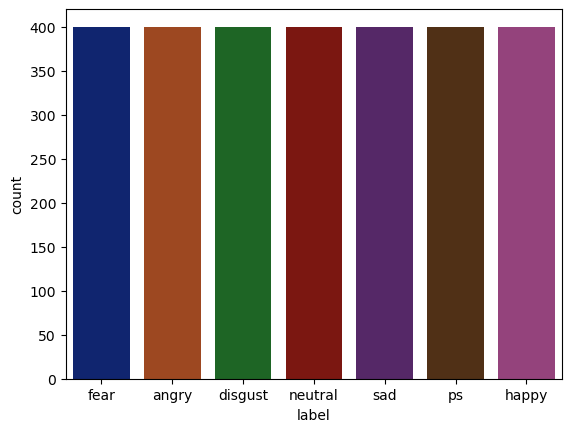

In [47]:
sns.countplot(x = df['label'], data=df, palette='dark')

This shows that all classes are equal in distribution

In [83]:
path = np.array(df['speech'][df['label']=='neutral'])[0]
Audio(path)

In [82]:
path = np.array(df['speech'][df['label']=='fear'])[0]
Audio(path)

In [81]:
path = np.array(df['speech'][df['label']=='angry'])[0]
Audio(path)

In [80]:
path = np.array(df['speech'][df['label']=='disgust'])[0]
Audio(path)

In [79]:
path = np.array(df['speech'][df['label']=='ps'])[0]
Audio(path)

Note that ps stands for pleasant-surprised

In [78]:
path = np.array(df['speech'][df['label']=='sad'])[0]
Audio(path)

In [77]:
path = np.array(df['speech'][df['label']=='happy'])[0]
Audio(path)

In [52]:
def waveplot(data, sr, emotion):
    lab='Waveplot of '+emotion
    plt.figure(figsize=(10,4))
    plt.title(lab, size=20)
    librosa.display.waveshow(data, sr=sr)
    plt.show()
    
def spectogram(data, sr, emotion):
     x = librosa.stft(data)
     lab='Spectogram of '+emotion
     xdb = librosa.amplitude_to_db(abs(x))
     plt.figure(figsize=(11,4))
     plt.title(lab, size=20)
     librosa.display.specshow(xdb, sr=sr, x_axis='time', y_axis='hz')
     plt.colorbar()

Here we have defined two functions:
* **waveplot() to view the waveform of the audio file**: it's a visual representation of an audio waveform. It's a graphical way to display how the amplitude (loudness) of a sound signal changes over time.

* **spectogram()  to view the frequency levels of the audio file**: A spectrogram breaks down an audio signal into its constituent frequencies, showing how these frequencies change over time. This makes it particularly useful for tasks like identifying individual notes in music, detecting certain sound patterns, analyzing the structure of speech, and much more. This is why it is more useful than a waveplot.

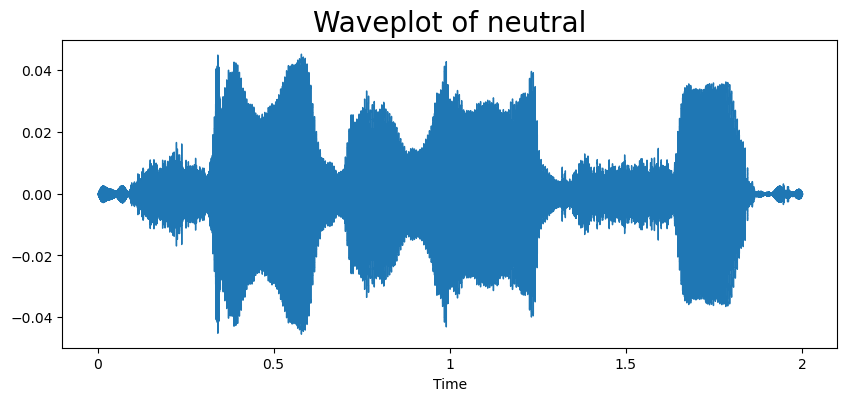

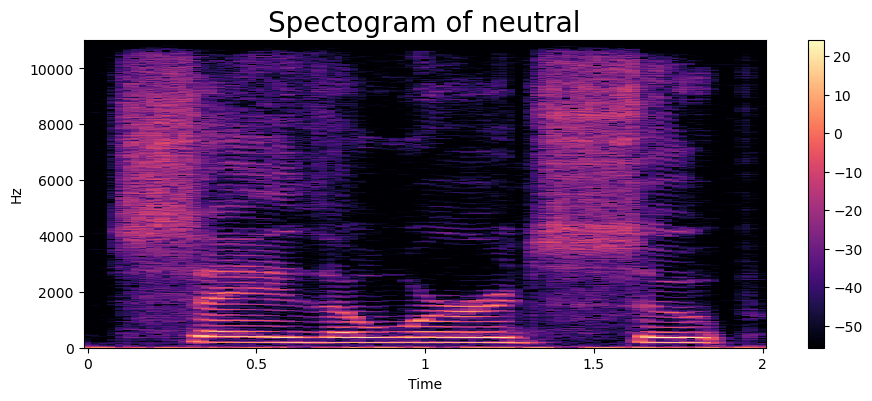

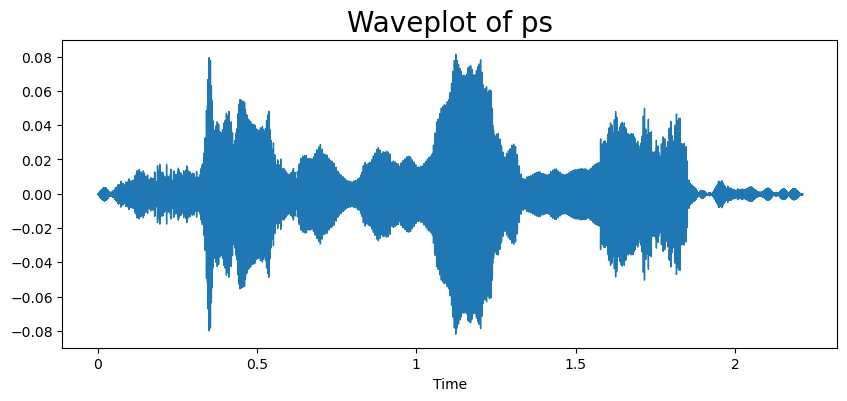

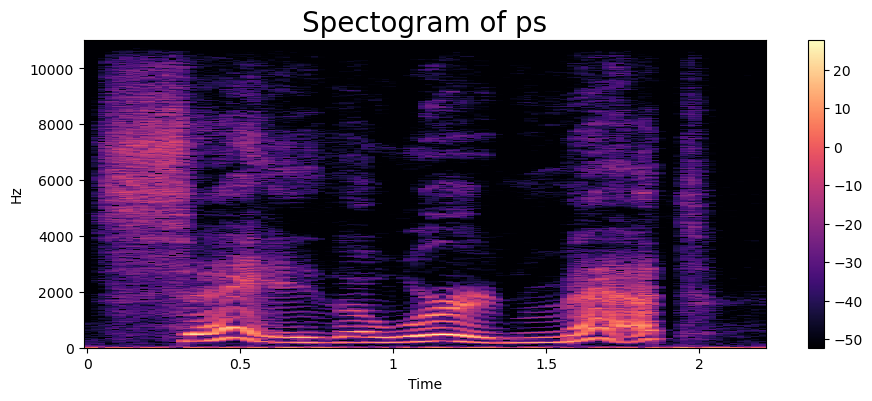

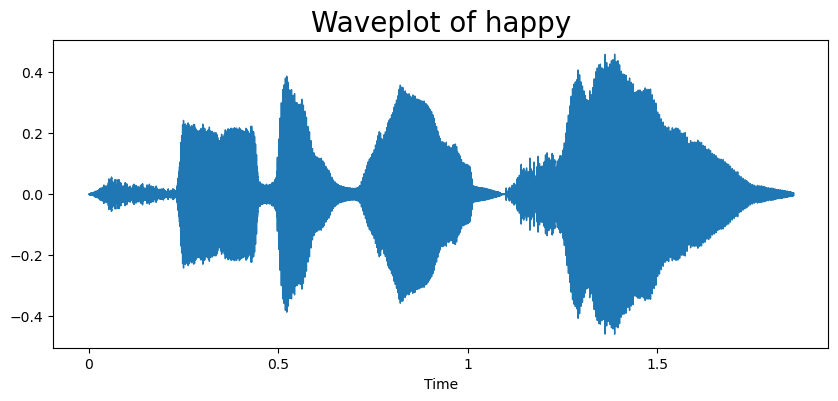

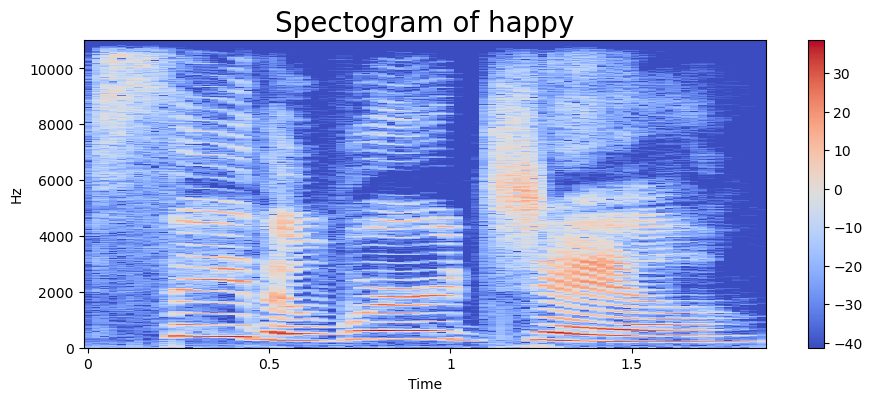

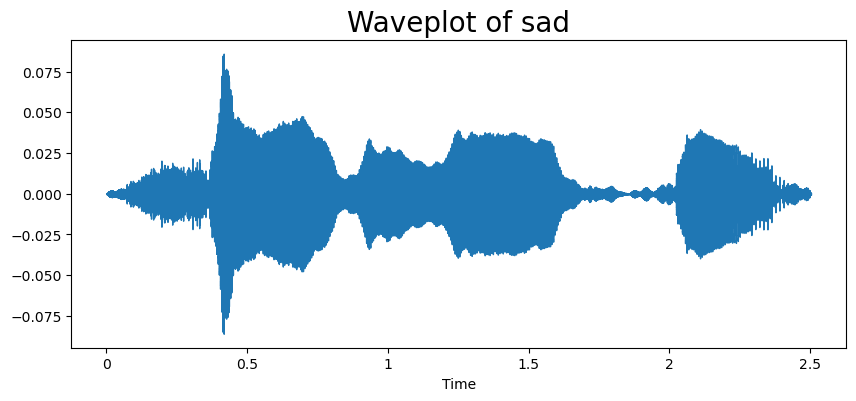

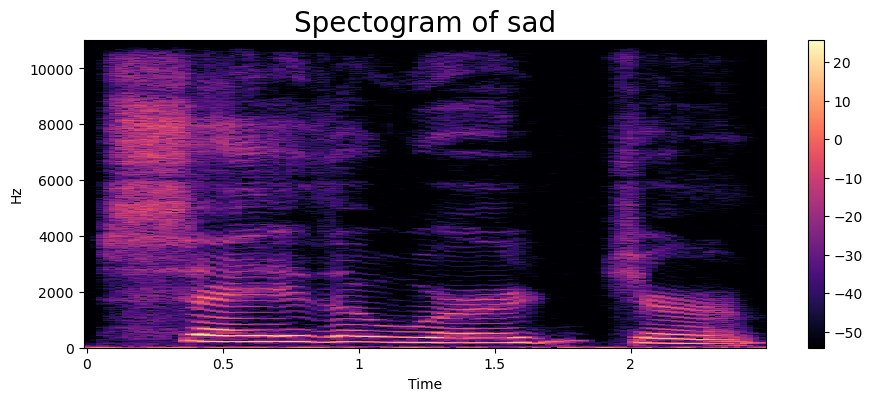

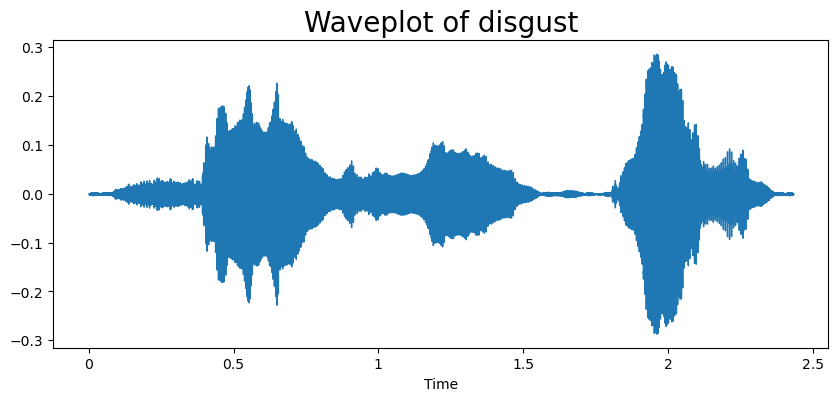

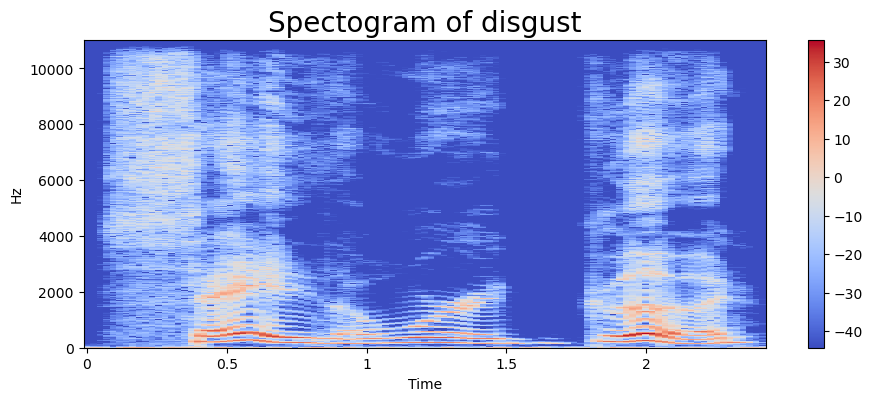

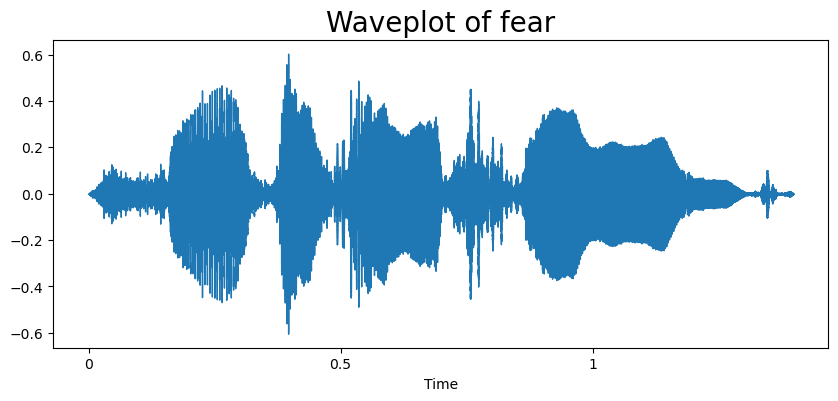

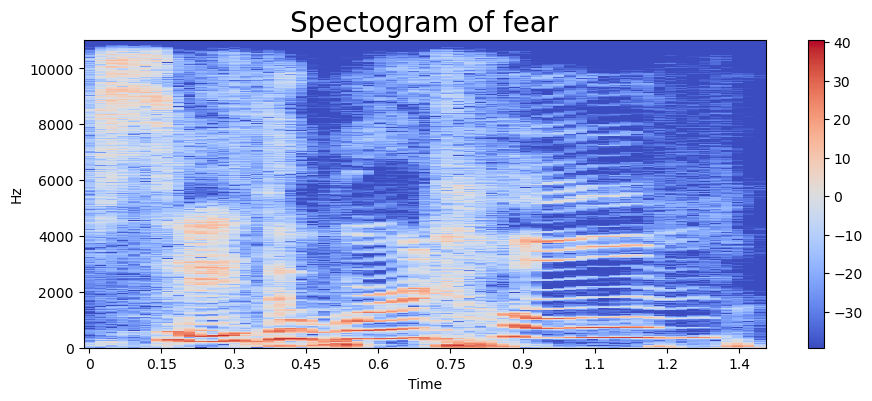

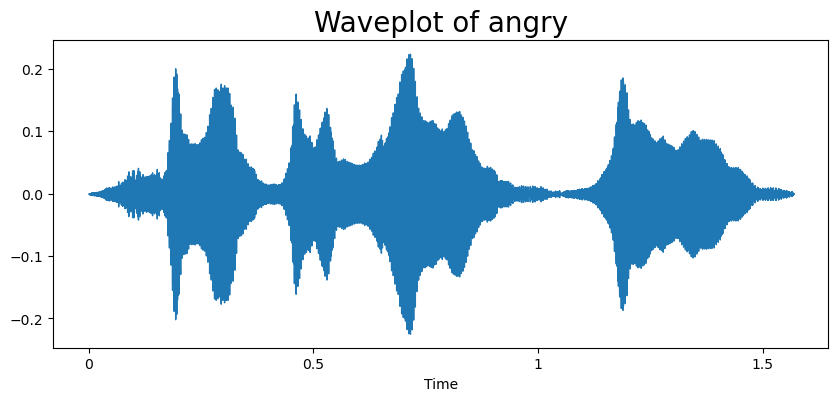

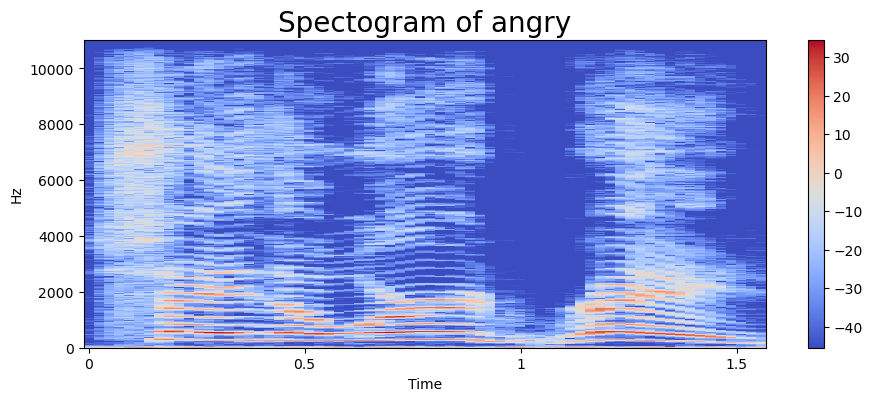

In [65]:
emo=list(set(labels))
for i in range(0,len(emo)):
    emotion = emo[i]
    path = np.array(df['speech'][df['label']==emotion])[0]
    data, sampling_rate = librosa.load(path)
    waveplot(data, sampling_rate, emotion)
    spectogram(data, sampling_rate, emotion)
    Audio(path)

* Lower pitched voices have darker colors

* Higher pitched voices have more brighter colors

# FEATURE EXTRACTION

We shall use **MFCC** for feature extraction: Mel-Frequency Cepstral Coefficients (MFCCs) are like special features that help the computer understand sounds.They capture the spectral characteristics of audio signals and are widely used in tasks like speech recognition, speaker identification, music genre classification, and more. Imagine breaking down the sound into different frequency parts and then figuring out how much energy is in each part. We then make these energy values look more like how our ears hear sounds. After that, we arrange and compress these values using math. The resulting set of compressed values, called MFCCs, become a kind of special code that describes the important parts of the sound. 

Here we have defined a function for the same which will extract the MFCC features with the limit of 40 and take the mean as the final feature

In [85]:
def extract_mfcc(filename):
     y, sr = librosa.load(filename, duration=3, offset=0.5)
     mfcc = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40).T, axis=0)
     return mfcc

In [86]:
extract_mfcc(df['speech'][0])

array([-285.73727   ,   85.78295   ,   -2.1689112 ,   22.125532  ,
        -14.757395  ,   11.051346  ,   12.412449  ,   -3.0002618 ,
          1.0844991 ,   11.078272  ,  -17.41966   ,   -8.093213  ,
          6.5879726 ,   -4.2209535 ,   -9.15508   ,    3.52148   ,
        -13.186381  ,   14.078853  ,   19.66973   ,   22.725618  ,
         32.57464   ,   16.325035  ,   -3.8427293 ,    0.89629656,
        -11.239262  ,    6.653462  ,   -2.5883696 ,   -7.7140164 ,
        -10.941658  ,   -2.4007547 ,   -5.281288  ,    4.271157  ,
        -11.202216  ,   -9.024621  ,   -3.6669848 ,    4.869744  ,
         -1.6027985 ,    2.5600514 ,   11.454374  ,   11.233449  ],
      dtype=float32)

In [87]:
X_mfcc = df['speech'].apply(lambda x: extract_mfcc(x))

In [88]:
X_mfcc

0       [-285.73727, 85.78295, -2.1689112, 22.125532, ...
1       [-348.34332, 35.193233, -3.841328, 14.658875, ...
2       [-340.11435, 53.796444, -14.267782, 20.884027,...
3       [-306.63422, 21.259708, -4.4110823, 6.4871554,...
4       [-344.7548, 46.329193, -24.171413, 19.392921, ...
                              ...                        
2795    [-374.3952, 60.864998, 0.025059083, 8.431058, ...
2796    [-313.96478, 39.847843, -5.6493053, -3.867575,...
2797    [-357.54886, 77.886055, -15.224756, 2.194633, ...
2798    [-353.1474, 101.68391, -14.175896, -12.037376,...
2799    [-389.4595, 54.042767, 1.346998, -1.4258983, -...
Name: speech, Length: 2800, dtype: object

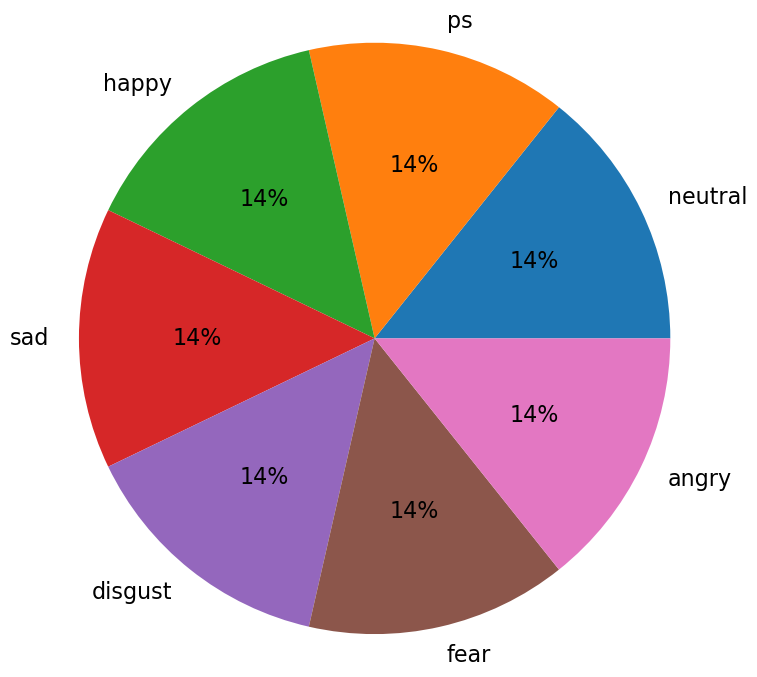

In [89]:
plt.pie(df['label'].value_counts(), labels = emo, autopct = '%.0f%%', radius= 2, textprops={'fontsize': 16})
plt.show()

We can also check the average pitch:

In [93]:
def compute_average_pitch(filename):
    audio_signal, sampling_rate = librosa.load(filename, sr=None)
    harmonic, percussive = librosa.effects.hpss(audio_signal)
    pitch, magnitudes = librosa.piptrack(y=harmonic, sr=sampling_rate)
    pitch_values = pitch[np.argmax(magnitudes, axis=0)]
    average_pitch = np.mean(pitch_values)

    return average_pitch
print('Average pitch is ',compute_average_pitch(df['speech'][0]))

Average pitch is  44.073532


Since X_mfcc is in the form of a list we convert it into a 2D array

In [104]:
X = [x for x in X_mfcc]
X = np.array(X)
X.shape

(2800, 40)

In [106]:
## input split
X = np.expand_dims(X, -1)
X.shape

(2800, 40, 1, 1)

In [108]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()
y = enc.fit_transform(df[['label']])
y = y.toarray()
y.shape

(2800, 7)

In [111]:
y[0]

array([0., 0., 1., 0., 0., 0., 0.])

We used OneHotEncoder to convert the labels into categorical form. We have converted the data into this kind of array because it is accepted by the LSTM Model

# Create the LSTM Model

An LSTM (Long Short-Term Memory) model is like a smart computer tool that's really good at understanding and remembering sequences of things, like words in a sentence or sounds in speech. It's built using math and patterns that help it capture long-term relationships in the sequence. An LSTM learns to remember and use information from different parts of a sequence to make predictions or understand patterns in the data.

In [109]:
# show the label mapped values
label_index_mapping = {i: label for i, label in enumerate(enc.categories_[0])}
print(label_index_mapping)

{0: 'angry', 1: 'disgust', 2: 'fear', 3: 'happy', 4: 'neutral', 5: 'ps', 6: 'sad'}


In [110]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

model = Sequential([
    LSTM(256, return_sequences=False, input_shape=(40,1)),
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(7, activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 256)               264192    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 7)                 4

* Dense - single dimension linear layer with hidden units

* Dropout - used to add regularization to the data, avoiding over fitting & dropping out a fraction of the data

* Loss='sparse_categorical_crossentropy' - computes the cross-entropy loss between true labels and predicted labels.

* Optimizer='adam' - automatically adjust the learning rate for the model over the number of epochs

**Training the model**

In [116]:
history = model.fit(X, y, validation_split=0.2, epochs=50, batch_size=64)

Epoch 1/50
35/35 [==============================] - 5s 133ms/step - loss: 1.8132e-04 - accuracy: 1.0000 - val_loss: 4.6371 - val_accuracy: 0.5571
Epoch 2/50
35/35 [==============================] - 5s 131ms/step - loss: 2.0497e-04 - accuracy: 1.0000 - val_loss: 4.7449 - val_accuracy: 0.5571
Epoch 3/50
35/35 [==============================] - 5s 135ms/step - loss: 0.0188 - accuracy: 0.9955 - val_loss: 4.1277 - val_accuracy: 0.5786
Epoch 4/50
35/35 [==============================] - 5s 133ms/step - loss: 0.0053 - accuracy: 0.9982 - val_loss: 3.4746 - val_accuracy: 0.6071
Epoch 5/50
35/35 [==============================] - 5s 136ms/step - loss: 0.0168 - accuracy: 0.9937 - val_loss: 4.5519 - val_accuracy: 0.5589
Epoch 6/50
35/35 [==============================] - 5s 139ms/step - loss: 0.0965 - accuracy: 0.9723 - val_loss: 2.8340 - val_accuracy: 0.4304
Epoch 7/50
35/35 [==============================] - 5s 129ms/step - loss: 0.0600 - accuracy: 0.9862 - val_loss: 3.0417 - val_accuracy: 0.562

Here, epoch means the number of iterations, i.e, in this case it is 50. We can increase it for better results. The training accuracy and validation accuracy increases each iteration. We can see that the accuracy reaches nearly 99%. Similarly, the validation accuracy is also mostly increasing. Therefore, we can say that this is a good model.

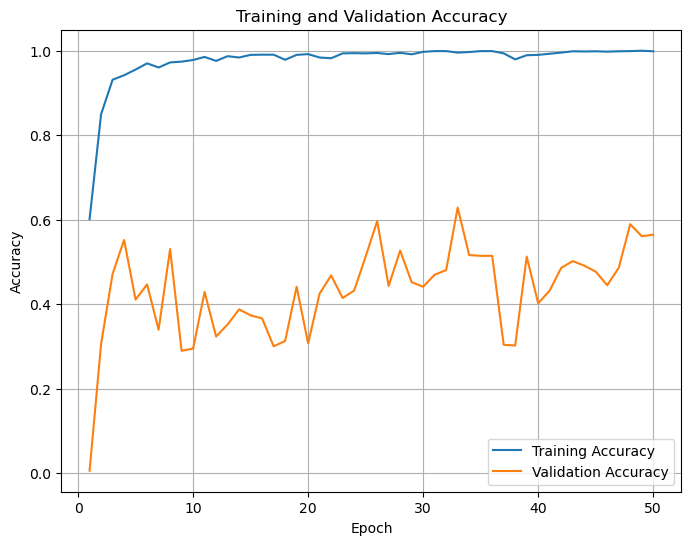

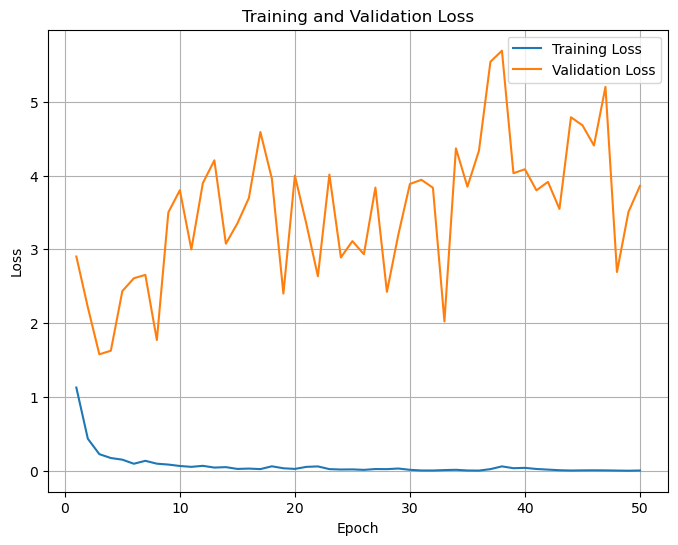

In [114]:
import matplotlib.pyplot as plt


train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 6))
plt.plot(range(1, len(train_accuracy) + 1), train_accuracy, label='Training Accuracy')
plt.plot(range(1, len(val_accuracy) + 1), val_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()


plt.figure(figsize=(8, 6))
plt.plot(range(1, len(train_loss) + 1), train_loss, label='Training Loss')
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()


* The graph for accuracy shows that accuracy for training increases steadily and stabilizes near 0.9. For the validation accuracy there are more jumps but there is a slight increasing trend. Overall it's a moderately good model. We can use more data for better results.

* For the loss graph: In an ideal scenario, both losses decrease as the model learns from the data, with the validation loss trailing slightly behind the training loss. This indicates that the model is learning meaningful patterns without overfitting. However, if the validation loss starts to increase or remains stagnant while the training loss drops, it suggests that the model might not be generalizing well and adjustments might be needed to prevent overfitting. In this case, the training loss decreases however, validation loss is not decreasing simultaneously, nor is it remaining stagnant. It's a moderate accuracy overall.
